In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib as mpl

from os.path import join

plt.style.use(["seaborn", "thesis"])
plt.rcParams["figure.figsize"] = (8, 4)

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Molecule 

In [2]:
from SCFInitialGuess.utilities.dataset import Molecule

angle_HCC = 121.3/180 *np.pi
distance_CC = 1.339
distance_CH = 1.087

mol = Molecule(
    species=["H", "H"],
    positions=[
        [0.00000,       0.00000,        0.00000],
        [1.00000,       0.00000,        0.00000],
        #[1/np.sqrt(2),    1/np.sqrt(2),     0.00000]
    ]
)

No handles with labels found to put in legend.


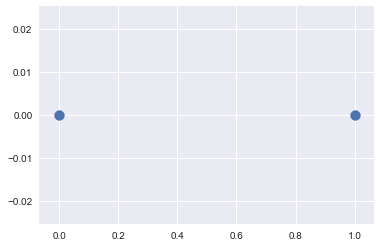

In [3]:
pos = np.array(mol.positions)
plt.scatter(pos[:, 0], pos[:, 1])
plt.legend()

# Utilities 

In [4]:
def activation(r, phi, theta, descriptor, values):
    
    radial_descriptor = descriptor.radial_descriptor
    angular_descriptor = descriptor.angular_descriptor
    
    return radial_descriptor.calculate_inverse_descriptor(
        r, 
        values[:radial_descriptor.number_of_descriptors]
    ) * angular_descriptor.calculate_inverse_descriptor(
        phi,
        theta,
        values[radial_descriptor.number_of_descriptors:]
    ) # TODO maybe add cutoff

# Initialize Descriptors

## Utilities 

In [5]:
def plot_normal_model(model, t):
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t, np.exp(-1 * eta*(t - r_s)**2))
        
def plot_periodic_model(model, t):
    period = model[2]
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t,
            np.exp(-1 * eta * ((t % period) - r_s)**2) + \
            np.exp(-1 * eta * ((t % period) - period - r_s)**2)
        )

## Low Level 

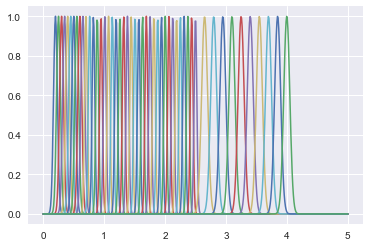

In [6]:
r_model_concentrated = (
    list(np.linspace(0.2, 0.7, 11))[:-1] + \
    list(np.linspace(0.7, 2.5, 30)) + \
    list(np.linspace(2.5, 4, 11))[1:],
    [500]*10 + \
    [1000]*30 + \
    [200]*10,
)

plot_normal_model(r_model_concentrated, np.linspace(0, 5, 500))

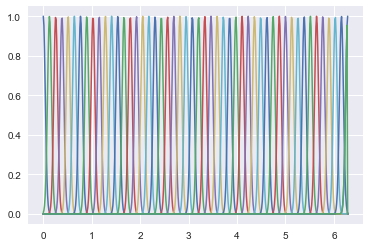

In [7]:
phi_model_evenly = (
    np.linspace(0, 2*np.pi, 50),
    [300] * 50,
    2 * np.pi
)

plot_periodic_model(phi_model_evenly, np.linspace(0, 2 * np.pi, 500))

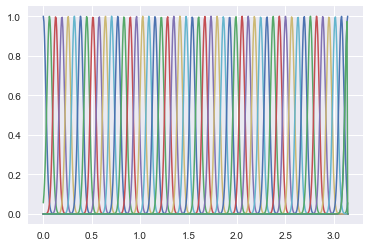

In [8]:
theta_model_evenly = (
    np.linspace(0, np.pi, 50),
    [700] * 50,
    np.pi
)

plot_periodic_model(theta_model_evenly, np.linspace(0, np.pi, 500))

## High Level

In [9]:
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, PeriodicGaussians
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    BehlerCutoff1
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    IndependentAngularDescriptor, NonWeighted
    
    
descriptor = NonWeighted(
    Gaussians(*r_model_concentrated),
    IndependentAngularDescriptor(
        PeriodicGaussians(*phi_model_evenly),
        PeriodicGaussians(*theta_model_evenly),
    ),
    BehlerCutoff1(5)
)

# C1 

In [10]:
values = descriptor.calculate_atom_descriptor(
    0,
    mol,
    descriptor.number_of_descriptors
)

## Radial 

In [11]:
n_radial = descriptor.radial_descriptor.number_of_descriptors
radial_values = values[:n_radial]

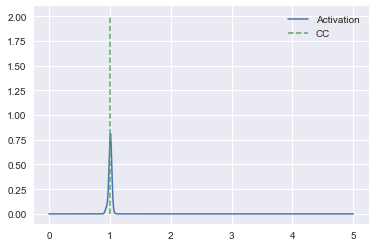

In [12]:
r = np.linspace(0, 5, 500)
plt.plot(
    r, 
    descriptor.radial_descriptor.calculate_inverse_descriptor(r, radial_values),
    label="Activation"
)
plt.plot([1.0]*2, [0, 2], "--", label="CC")

plt.legend()

## Angular 

In [13]:
n_azimuthal = descriptor.angular_descriptor.azimuthal_descriptor.number_of_descriptors

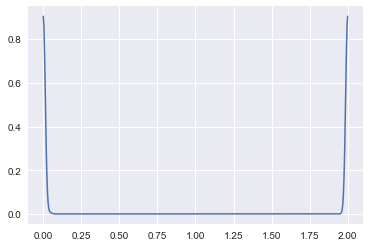

In [14]:
phi = np.linspace(0, 2 * np.pi, 500)

plt.plot(
    phi / (np.pi ),
    descriptor.angular_descriptor.azimuthal_descriptor.calculate_inverse_descriptor(
        phi,
        values[n_radial:(n_radial + n_azimuthal)]
    )
)

## Polar 

In [15]:
n_polar = descriptor.angular_descriptor.polar_descriptor.number_of_descriptors

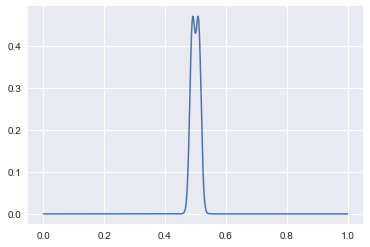

In [16]:
theta = np.linspace(0, np.pi, 500)

plt.plot(
    theta / (np.pi),
    descriptor.angular_descriptor.polar_descriptor.calculate_inverse_descriptor(
        theta,
        values[(n_radial + n_azimuthal):]
    )
)

## Surface 

/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


Text(0.5,0,'$\\phi$ / 1/$\\phi$')

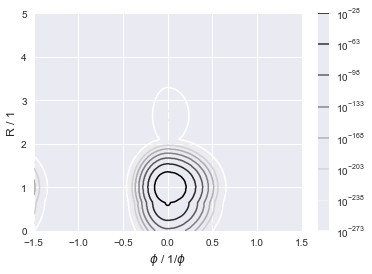

In [17]:
R, Phi = np.meshgrid(r, np.linspace(- 1.5 * np.pi, 1.5 * np.pi, 500))

theta = np.pi / 2

z = activation(
    R.flatten(),
    Phi.flatten(),
    theta,
    descriptor,
    values
)


plt.contour(
    Phi / np.pi,
    R,
    z.reshape(*R.shape),
    locator=mpl.ticker.LogLocator()
)
plt.colorbar()
plt.ylabel("R / 1")
plt.xlabel("$\phi$ / 1/$\phi$")

/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


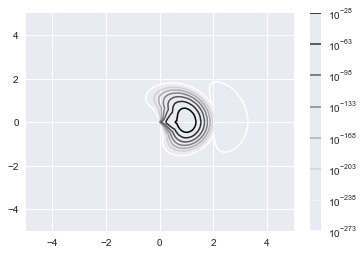

In [18]:
R, Phi = np.meshgrid(r, np.linspace(0, 2 * np.pi, 500))

theta = np.pi / 2

z = activation(
    R.flatten(),
    Phi.flatten(),
    theta,
    descriptor,
    values
)

plt.contour(
    (R * np.cos(Phi)),
    (R * np.sin(Phi)),
    z.reshape(*R.shape),
    locator=mpl.ticker.LogLocator()
)
plt.colorbar()